1.获取json_config_path和学习率alpha设置

In [43]:
#import argparse #argparse是python用于解析命令行参数和选项的标准模块
import os
import json

json_config_path=".\configs.json"
alpha=0.75
input_shape=(224,224,3)
input_size=224

if os.path.exists(json_config_path)==False: #如果设置路径中不存在
    print("没有找到配置文件,请重新选择.")
else:
    f = open(json_config_path, "r",encoding='utf-8') #打开路径中的config文件
    setting = json.load(f) #加载json文件 json.load()->读取文件 返回类似字典

2.获取两个需要的数据:         (1)config字典(读取自对应的json文件)        (2)保存Weight file的路径

In [44]:
import shutil   #作为os模块的补充,提供了复制,移动,删除,压缩,解压等操作

def setup_training(config_file):  #传入:config_file->指定的config路径  传出:config字典(读取自对应的json文件), 保存Weight file的路径
    with open(config_file,encoding='utf-8') as config_buffer: #打开config_file路径中的config文件
        config = json.loads(config_buffer.read())  #读取文本,返回config字典 json.loads()->用来读取文本
    dirname = config['train']['saved_folder'] #dirname获取保存Weight file的文件夹
    if os.path.isdir(dirname): #如果路径存在
        print("{} is already exists. Weight file in directory will be overwritten".format(dirname))
    else:
        print("{} is created.".format(dirname, dirname))
        os.makedirs(dirname)   #创建文件夹
    print("Weight file and Config file will be saved in \"{}\"".format(dirname))
    # shutil.copyfile(config_file, os.path.join(dirname, "config.json")) #复制文件,前->后,将config_file文件复制到  (保存Weight file的文件夹)\test路径下
    return config, os.path.join(dirname, "weights.h5") #返回config字典(读取自对应的json文件), 保存Weight file的路径

config, weight_file = setup_training(json_config_path)  #传入:json_config_path->指定的config路径  传出:config字典(读取自对应的json文件), 保存Weight file的路径

test is already exists. Weight file in directory will be overwritten
Weight file and Config file will be saved in "test"


 3.定义DW卷积

In [45]:
from tensorflow.keras import layers,backend,models,utils
#初始卷积,正则化,relu6激活函数
def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):#初始化卷积层,输入img_input=(224x224x3),通道数,mobilenet学习率,步长
    filters = int(filters * alpha)#利用alpha减少通道数
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv1_pad')(inputs)
    x = layers.Conv2D(filters, kernel,
                      padding='valid',
                      use_bias=False,
                      strides=strides,
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=-1, name='conv1_bn')(x)
    return layers.ReLU(6., name='conv1_relu')(x)



#inputs->输入张量   pointwise_conv_filters->输出通道数  alpha->学习率  depth_multiplier->倍率因子 strides->步长
#实际执行的操作时dw卷积->bn->relu6->1x1卷积->bn->relu6  输出通道数为pointwise_conv_filters*alpha
def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha,#input->输入张量
                          depth_multiplier=1, strides=(1, 1), block_id=1):
   
    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1 #channel_axis-> -1 
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    if strides == (1, 1):
        x = inputs
    else:
        x = layers.ZeroPadding2D(((1, 1), (1, 1)),
                                 name='conv_pad_%d' % block_id)(inputs)
    x = layers.DepthwiseConv2D((3, 3),                                          #做dw卷积,strides=1时不改变维度,strides=2时降采样
                               padding='same' if strides == (1, 1) else 'valid',#注意dw卷积不改变图像的通道数
                               depth_multiplier=depth_multiplier,
                               strides=strides,
                               use_bias=False,
                               name='conv_dw_%d' % block_id)(x)
    x = layers.BatchNormalization(
        axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
    x = layers.ReLU(6., name='conv_dw_%d_relu' % block_id)(x)

    x = layers.Conv2D(pointwise_conv_filters, (1, 1),
                      padding='same',
                      use_bias=False,
                      strides=(1, 1),
                      name='conv_pw_%d' % block_id)(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  name='conv_pw_%d_bn' % block_id)(x)
    return layers.ReLU(6., name='conv_pw_%d_relu' % block_id)(x)

4.创建mobilenet主干特征提取网络

In [46]:
img_input = layers.Input(shape=input_shape)#定义输入层shape为224x224x3
depth_multiplier=1
#初始卷积,正则化,relu6激活函数
#224x224x3
x = _conv_block(img_input, 32, alpha, strides=(2, 2))#初始化卷积层,输入img_input=(224x224x3),通道数,mobilenet学习率,步长
#112x112x(32xalpha)
#实际执行的操作时dw卷积->bn->relu6->1x1卷积->bn->relu6  输出通道数为pointwise_conv_filters*alpha
x = _depthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=1)   #inputs->输入张量   pointwise_conv_filters->输出通道数  
                                                                            # alpha->学习率  depth_multiplier->倍率因子 strides->步长
#112x112x(64xalpha)  
x = _depthwise_conv_block(x, 128, alpha, depth_multiplier,
                              strides=(2, 2), block_id=2)
#56x56x(128xalpha) 
x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3)
    #56x56x(128xalpha) 
x = _depthwise_conv_block(x, 256, alpha, depth_multiplier,
                              strides=(2, 2), block_id=4)
    #28x28x(256xalpha) 
x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5)
    #28x28x(256xalpha) 
x = _depthwise_conv_block(x, 512, alpha, depth_multiplier,
                              strides=(2, 2), block_id=6)
    #14x14x(512xalpha)  5次卷积块运算
x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7)
x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8)
x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9)
x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10)
x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11)
    #14x14x(512xalpha)
x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier,
                              strides=(2, 2), block_id=12)
    #7x7x(1024xalpha)
x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)
    #7x7x(1024xalpha)

inputs = img_input
model = models.Model(inputs, x, name='mobilenet_%0.2f'%(alpha))#创建模型
#  model->自己创建的模型对象(即为mobilenetv1,不进行pooling和拉直操作)

5.定义一个mobilenet主干特征提取网络类

In [47]:
class MobileNetFeature():
    """docstring for ClassName"""
    def __init__(self):
        self.feature_extractor = model

    def normalize(self, image):#定义bn化函数
        image = image / 255.
        image = image - 0.5
        image = image * 2.
        return image	

    def get_input_size(self): #获取输入层的size
        input_shape = self.feature_extractor.get_input_shape_at(0)
        print("+++++++++"+input_shape[1],input_shape[2])
        return input_shape[1]

    def get_output_size(self):#获取输出层的size
        output_shape = self.feature_extractor.layers[-1].output_shape
        return output_shape[1]

feature_extractor=MobileNetFeature()

6.定义一个完整的yolo网络

In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Conv2D, Input, Lambda
from tensorflow.keras.models import Model
import numpy as np
np.random.seed(111)
class YoloNetwork(object):
    def __init__(self,
                 feature_extractor,             #主干特征提取网络对象
                 nb_classes,                    #获取要检测的类别数量
                 nb_box):                       #获取先验框的数量
        # 1. create full network
        grid_size = feature_extractor.get_output_size()#获取到输出的栅格大小为7

        # make the object detection layer
        output_tensor = Conv2D(nb_box * (4 + 1 + nb_classes), (1,1), strides=(1,1),
                               padding='same', 
                               name='detection_layer_{}'.format(nb_box * (4 + 1 + nb_classes)), 
                               kernel_initializer='lecun_normal')(feature_extractor.feature_extractor.output)   #kernel_initializer->卷积内核的初始化程序->LeCun正态分布
        #再次经过一层卷积 7x7x(1024xalpha)->7x7*[nb_box*(4+1+nb_classes)]
        output_tensor = Reshape((grid_size, grid_size, nb_box, 4 + 1 + nb_classes))(output_tensor)
        #经过一次reshape操作    7x7*nb_box*(4+1+nb_classes)->7*7*nb_box*(4+1+nb_classes)
        model = Model(feature_extractor.feature_extractor.input, output_tensor)    #定义一个模型,此为完整的yolov2网络

        self._norm = feature_extractor.normalize#定义bn化函数
        self._model = model
        self._model.summary()
        self._init_layer()#初始化权重设置

    def _init_layer(self):
        layer = self._model.layers[-2]#layer->获取最后的卷积层
        weights = layer.get_weights() #以含有Numpy矩阵的列表形式返回层的权重
        input_depth = weights[0].shape[-2] #获取mobilenet输出的通道数,为1024xalphaa
        new_kernel = np.random.normal(size=weights[0].shape)/ input_depth#重新生成卷积核的权重
        new_bias   = np.zeros_like(weights[1])#将conv层的bais置为0
        layer.set_weights([new_kernel, new_bias])#设置权重

    def load_weights(self, weight_path, by_name):#这个函数调用tf内置的load_weights函数加载权重
        self._model.load_weights(weight_path, by_name=by_name)
        
    def get_grid_size(self):#获取栅格的大小
        _, h, w, _, _ = self._model.layers[-1].output_shape
        return h
    def get_normalize_func(self):
        return self._norm
    def get_model(self, first_trainable_layer=None):
        layer_names = [layer.name for layer in self._model.layers]
        fixed_layers = []
        if first_trainable_layer in layer_names:
            for layer in self._model.layers:
                if layer.name == first_trainable_layer:
                    break
                layer.trainable = False
                fixed_layers.append(layer.name)

        if fixed_layers != []:
            print("The following layers do not update weights!!!")
            print("    ", fixed_layers)
        return self._model        


labels = config['model']['labels'] #获取config.json文件中的labels列表
print(labels)
anchors=config['model']['anchors'] #获取先验锚框列表
n_classes = len(labels)  #n_classes->获取要检测的类别数量
n_boxes = int(len(anchors)/2) #n_boxes->获取先验框的数量
yolo_net = YoloNetwork(feature_extractor,   #主干特征提取网络对象
                     n_classes,          #获取要检测的类别数量
                     n_boxes)              #获取先验框的数量

['Un_Masks', 'Masks']
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 24)      648       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 24)      96        
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 24)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 24)      216       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (No

自此,我们完成了整个YOLOv2网络的构建,并且得到了一个YoloNetwork对象yolo_net!!!!!!

In [49]:
def create_cell_grid(grid_size, batch_size):
    x_pos = tf.cast(tf.range(grid_size), tf.float32)
    y_pos = tf.cast(tf.range(grid_size), tf.float32)
    xx, yy = tf.meshgrid(x_pos, y_pos)
    xx = tf.expand_dims(xx, -1)
    yy = tf.expand_dims(yy, -1)
    
    grid = tf.concat([xx, yy], axis=-1)         # (7, 7, 2)
    grid = tf.expand_dims(grid, -2)             # (7, 7, 1, 2)
    grid = tf.tile(grid, (1,1,5,1))             # (7, 7, 5, 2)
    grid = tf.expand_dims(grid, 0)              # (1, 7, 7, 1, 2)
    grid = tf.tile(grid, (batch_size,1,1,1,1))  # (N, 7, 7, 1, 2)
    return grid


def get_loss(coord_mask, conf_mask, class_mask, pred_tensor, true_box_xy, true_box_wh, true_box_conf, true_box_class):
    nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0, tf.float32))
    nb_conf_box  = tf.reduce_sum(tf.cast(conf_mask  > 0.0, tf.float32))
    nb_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0, tf.float32))

    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = pred_tensor[..., :2], pred_tensor[..., 2:4], pred_tensor[..., 4], pred_tensor[..., 5:]
    # true_box_xy, true_box_wh, true_box_conf, true_box_class = true_tensor[..., :2], true_tensor[..., 2:4], true_tensor[..., 4], true_tensor[..., 5]
    true_box_class = tf.cast(true_box_class, tf.int64)
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    loss = loss_xy + loss_wh + loss_conf + loss_class
    return loss

class _Activator(object):
    
    def __init__(self, anchors=[0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]):
        self._anchor_boxes = np.reshape(anchors, [1,1,1,-1,2])#利用anchors列表创建对象 5个锚框reshape->[1,1,1,5,2]
        
    def run(self, y_true, y_pred):
        pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = self._activate_pred_tensor(y_pred)
        true_box_xy, true_box_wh, true_box_conf, true_box_class = self._activate_true_tensor(y_true, pred_box_xy, pred_box_wh)

        # concatenate pred tensor
        pred_box_conf = tf.expand_dims(pred_box_conf, -1)
        y_pred_activated = tf.concat([pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class], axis=-1)

        # concatenate true tensor
        true_box_conf = tf.expand_dims(true_box_conf, -1)
        true_box_class = tf.expand_dims(true_box_class, -1)
        true_box_class = tf.cast(true_box_class, true_box_xy.dtype)
        y_true_activated = tf.concat([true_box_xy, true_box_wh, true_box_conf, true_box_class], axis=-1)
        return y_true_activated, y_pred_activated
    
    def _activate_pred_tensor(self, y_pred):
        """
        # Args
            y_pred : (N, 13, 13, 5, 6)
            cell_grid : (N, 13, 13, 5, 2)
        
        # Returns
            box_xy : (N, 13, 13, 5, 2)
                1) sigmoid activation
                2) grid offset added
            box_wh : (N, 13, 13, 5, 2)
                1) exponential activation
                2) anchor box multiplied
            box_conf : (N, 13, 13, 5, 1)
                1) sigmoid activation
            box_classes : (N, 13, 13, 5, nb_class)
        """
        # bx = sigmoid(tx) + cx, by = sigmoid(ty) + cy
        batch_size = tf.shape(y_pred)[0]
        grid_size = tf.shape(y_pred)[1]
        cell_grid = create_cell_grid(grid_size, batch_size)
        
        pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
        pred_box_wh = tf.exp(y_pred[..., 2:4]) * self._anchor_boxes
        pred_box_conf = tf.sigmoid(y_pred[..., 4])
        pred_box_class = y_pred[..., 5:]
        return pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class
    def _activate_true_tensor(self, y_true, pred_box_xy, pred_box_wh):
        ### adjust x and y
        true_box_xy = y_true[..., 0:2] # relative position to the containing cell
        
        ### adjust w and h
        true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
        
        ### adjust confidence
        true_wh_half = true_box_wh / 2.
        true_mins    = true_box_xy - true_wh_half
        true_maxes   = true_box_xy + true_wh_half
        
        pred_wh_half = pred_box_wh / 2.
        pred_mins    = pred_box_xy - pred_wh_half
        pred_maxes   = pred_box_xy + pred_wh_half       
        
        intersect_mins  = tf.maximum(pred_mins,  true_mins)
        intersect_maxes = tf.minimum(pred_maxes, true_maxes)
        intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
        
        true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
        pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]
    
        union_areas = pred_areas + true_areas - intersect_areas
        iou_scores  = tf.truediv(intersect_areas, union_areas)
        
        true_box_conf = iou_scores * y_true[..., 4]
        
        ### adjust class probabilities
        true_box_class = tf.argmax(y_true[..., 5:], -1)
        
        return true_box_xy, true_box_wh, true_box_conf, true_box_class

class _Mask(object):
    #n_classes->获取要检测的类别数量   #坐标损失的系数=1  #分类损失系数=1   #有对象时的置信度损失=5  #无对象的损失系数=1
    def __init__(self, nb_class=1, coord_scale=1.0, class_scale=1.0, object_scale=5.0, no_object_scale=1.0):
        self._nb_class = nb_class
        self._coord_scale = coord_scale
        self._class_scale = class_scale
        self._object_scale = object_scale
        self._no_object_scale = no_object_scale
        
    def create_coord_mask(self, y_true):
        """ Simply the position of the ground truth boxes (the predictors)

        # Args
            y_true : Tensor, shape of (None, grid, grid, nb_box, 4+1+n_classes)
        
        # Returns
            mask : Tensor, shape of (None, grid, grid, nb_box, 1)
        """
        #     BOX 별 confidence value 를 mask value 로 사용
        # [1 13 13 5 1]
        BOX_IDX_CONFIDENCE=4
        mask = tf.expand_dims(y_true[..., BOX_IDX_CONFIDENCE], axis=-1) * self._coord_scale
        return mask
    
    def create_class_mask(self, y_true, true_box_class):
        """ Simply the position of the ground truth boxes (the predictors)

        # Args
            y_true : Tensor, shape of (None, grid, grid, nb_box, 4+1+n_classes)
            true_box_class : Tensor, shape of (None, grid, grid, nb_box)
                indicate class index per boxes
        
        # Returns
            mask : Tensor, shape of (None, grid, grid, nb_box)
        """
        class_wt = np.ones(self._nb_class, dtype='float32')
        mask = y_true[..., 4] * tf.gather(class_wt, true_box_class) * self._class_scale
        return mask
    
    def create_conf_mask(self, y_true, pred_tensor, batch_size):
        ### confidence mask: penelize predictors + penalize boxes with low IOU
        # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
        pred_box_xy, pred_box_wh = pred_tensor[..., :2], pred_tensor[..., 2:4]
        
        true_boxes = y_true[..., :4]
        true_boxes = tf.reshape(true_boxes, [batch_size, -1, 4])
        true_boxes = tf.expand_dims(true_boxes, 1)
        true_boxes = tf.expand_dims(true_boxes, 1)
        true_boxes = tf.expand_dims(true_boxes, 1)
        
        true_xy = true_boxes[..., 0:2]
        true_wh = true_boxes[..., 2:4]
        
        true_wh_half = true_wh / 2.
        true_mins    = true_xy - true_wh_half
        true_maxes   = true_xy + true_wh_half
        
        pred_xy = tf.expand_dims(pred_box_xy, 4)
        pred_wh = tf.expand_dims(pred_box_wh, 4)
        
        pred_wh_half = pred_wh / 2.
        pred_mins    = pred_xy - pred_wh_half
        pred_maxes   = pred_xy + pred_wh_half    
        
        intersect_mins  = tf.maximum(pred_mins,  true_mins)
        intersect_maxes = tf.minimum(pred_maxes, true_maxes)
        intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
        
        true_areas = true_wh[..., 0] * true_wh[..., 1]
        pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

        union_areas = pred_areas + true_areas - intersect_areas
        iou_scores  = tf.truediv(intersect_areas, union_areas)

        best_ious = tf.reduce_max(iou_scores, axis=4)
        # 1) confidence mask (N, 13, 13, 5)
        conf_mask  = tf.zeros(tf.shape(y_true)[:4])
        conf_mask = conf_mask + tf.cast(best_ious < 0.6, tf.float32) * (1 - y_true[..., 4]) * self._no_object_scale
        
        # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
        conf_mask = conf_mask + y_true[..., 4] * self._object_scale
        return conf_mask


class YoloLoss(object):
    
    def __init__(self,
                 grid_size=13,  #获取栅格的大小->7
                 nb_class=1,    #n_classes->获取要检测的类别数量
                 anchors=[0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828],#获取先验框
                 coord_scale=1.0,#坐标损失的系数=1
                 class_scale=1.0,#分类损失系数=1  
                 object_scale=5.0, #有对象时的置信度损失=5
                 no_object_scale=1.0):#无对象的损失系数=1
        """
        # Args
            grid_size : int
            batch_size : int
            anchors : list of floats
            nb_box : int
            nb_class : int
            true_boxes : Tensor instance
        """
        self.grid_size = grid_size #获取栅格大小
        self.anchors = anchors     #获取anchors列表
        self.nb_box = int(len(anchors)/2)#获取锚框的数量
        self.nb_class = nb_class       #获取要检测的类别数量

        self.coord_scale = coord_scale#坐标损失的系数=1

        # Todo : create method를 따로 만들어서 주입받자.
        self._activator = _Activator(self.anchors)#5个锚框reshape->[1,1,1,5,2]
        self._mask = _Mask(nb_class, coord_scale, class_scale, object_scale, no_object_scale)
        #n_classes->获取要检测的类别数量   #坐标损失的系数=1  #分类损失系数=1   #有对象时的置信度损失=5  #无对象的损失系数=1

    def custom_loss(self, batch_size):
        """
        # Args
            y_true : (N, 13, 13, 5, 6)
            y_pred : (N, 13, 13, 5, 6)
        
        """
        def loss_func(y_true, y_pred):
            # 1. activate prediction & truth tensor
            true_tensor, pred_tensor = self._activator.run(y_true, y_pred)
            true_box_xy, true_box_wh, true_box_conf, true_box_class = true_tensor[..., :2], true_tensor[..., 2:4], true_tensor[..., 4], true_tensor[..., 5]
            true_box_class = tf.cast(true_box_class, tf.int64)

            # 2. mask
            coord_mask = self._mask.create_coord_mask(y_true)
            class_mask = self._mask.create_class_mask(y_true, true_box_class)
            conf_mask = self._mask.create_conf_mask(y_true, pred_tensor, batch_size)
            
            """
            Finalize the loss
            """
            loss = get_loss(coord_mask, conf_mask, class_mask, pred_tensor, true_box_xy, true_box_wh, true_box_conf, true_box_class)
            return loss
        return loss_func

In [50]:
#返回一个设置好权重,完整的mobilenetv1-yolo网络
yolo_loss = YoloLoss(yolo_net.get_grid_size(),  #获取栅格的大小->7
                    n_classes,                     #n_classes->获取要检测的类别数量
                    anchors,                       #获取先验框
                    config['model']['coord_scale'],     #坐标损失的系数=1
                    config['model']['class_scale'],     #分类损失系数=1
                    config['model']['object_scale'],    #有对象时的置信度损失=5
                    config['model']['no_object_scale']) #无对象的损失系数=1

In [51]:
def to_minmax(centroid_boxes):
    centroid_boxes = centroid_boxes.astype(np.float)
    minmax_boxes = np.zeros_like(centroid_boxes)
    
    cx = centroid_boxes[:,0]
    cy = centroid_boxes[:,1]
    w = centroid_boxes[:,2]
    h = centroid_boxes[:,3]
    
    minmax_boxes[:,0] = cx - w/2
    minmax_boxes[:,1] = cy - h/2
    minmax_boxes[:,2] = cx + w/2
    minmax_boxes[:,3] = cy + h/2
    return minmax_boxes


def centroid_box_iou(box1, box2):
    def _interval_overlap(interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
    
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2,x4) - x1
        else:
            if x2 < x3:
                return 0
            else:
                return min(x2,x4) - x3
    
    _, _, w1, h1 = box1.reshape(-1,)
    _, _, w2, h2 = box2.reshape(-1,)
    x1_min, y1_min, x1_max, y1_max = to_minmax(box1.reshape(-1,4)).reshape(-1,)
    x2_min, y2_min, x2_max, y2_max = to_minmax(box2.reshape(-1,4)).reshape(-1,)
            
    intersect_w = _interval_overlap([x1_min, x1_max], [x2_min, x2_max])
    intersect_h = _interval_overlap([y1_min, y1_max], [y2_min, y2_max])
    intersect = intersect_w * intersect_h
    union = w1 * h1 + w2 * h2 - intersect
    
    return float(intersect) / union


class BoundBox:
    def __init__(self, x, y, w, h, c = None, classes = None):
        self.x     = x
        self.y     = y
        self.w     = w
        self.h     = h
        
        self.c     = c
        self.classes = classes

    def get_label(self):
        return np.argmax(self.classes)
    
    def get_score(self):
        return self.classes[self.get_label()]
    
    def iou(self, bound_box):
        b1 = self.as_centroid()
        b2 = bound_box.as_centroid()
        return centroid_box_iou(b1, b2)

    def as_centroid(self):
        return np.array([self.x, self.y, self.w, self.h])

def nms_boxes(boxes, n_classes, nms_threshold=0.3, obj_threshold=0.3):
    """
    # Args
        boxes : list of BoundBox
    
    # Returns
        boxes : list of BoundBox
            non maximum supressed BoundBox instances
    """
    # suppress non-maximal boxes
    for c in range(n_classes):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            if boxes[index_i].classes[c] == 0: 
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]

                    if boxes[index_i].iou(boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0
    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    return boxes


def boxes_to_array(bound_boxes):
    """
    # Args
        boxes : list of BoundBox instances
    
    # Returns
        centroid_boxes : (N, 4)
        probs : (N, nb_classes)
    """
    centroid_boxes = []
    probs = []
    for box in bound_boxes:
        centroid_boxes.append([box.x, box.y, box.w, box.h])
        probs.append(box.classes)
    return np.array(centroid_boxes), np.array(probs)

class YoloDecoder(object):

    #传入先验框
    def __init__(self,
                 anchors = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828],
                 nms_threshold=0.2):
        self._anchors = anchors
        self._nms_threshold = nms_threshold#nms抑制的阈值

    def run(self, netout, obj_threshold=0.3):
        """Convert Yolo network output to bounding box
        
        # Args
            netout : 4d-array, shape of (grid_h, grid_w, num of boxes per grid, 5 + n_classes)
                YOLO neural network output array
        
        # Returns
            boxes : array, shape of (N, 4)
                coordinate scale is normalized [0, 1]
            probs : array, shape of (N, nb_classes)
        """
        grid_h, grid_w, nb_box = netout.shape[:3]

        boxes = []
        
        # decode the output by the network
        netout[..., 4]  = _sigmoid(netout[..., 4])
        netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
        netout[..., 5:] *= netout[..., 5:] > obj_threshold
        
        for row in range(grid_h):
            for col in range(grid_w):
                for b in range(nb_box):
                    # from 4th element onwards are confidence and class classes
                    classes = netout[row,col,b,5:]
                    
                    if np.sum(classes) > 0:
                        # first 4 elements are x, y, w, and h
                        x, y, w, h = netout[row,col,b,:4]

                        x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                        y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                        w = self._anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                        h = self._anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                        confidence = netout[row,col,b,4]
                        box = BoundBox(x, y, w, h, confidence, classes)
                        boxes.append(box)
        
        boxes = nms_boxes(boxes, len(classes), self._nms_threshold, obj_threshold)
        boxes, probs = boxes_to_array(boxes)
        return boxes, probs

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)
    if np.min(x) < t:
        x = x/np.min(x)*t
    e_x = np.exp(x)
    return e_x / e_x.sum(axis, keepdims=True)


yolo_decoder = YoloDecoder(anchors) #传入先验框

In [52]:
class Annotation(object):
    """
    # Attributes
        fname : image file path
        labels : list of strings
        boxes : Boxes instance
    """
    def __init__(self, filename):#传入xml对应的img路径,获得一个annotation类
        self.fname = filename
        self.labels = []
        self.boxes = None

    def add_object(self, x1, y1, x2, y2, name):#传入锚框的4个点和标签,添加Annotation类的labels成员和boxes成员,labels为列表,boxes的维度是[n,4]
        self.labels.append(name)
        if self.boxes is None:
            self.boxes = np.array([x1, y1, x2, y2]).reshape(-1,4)
        else:
            box = np.array([x1, y1, x2, y2]).reshape(-1,4)
            self.boxes = np.concatenate([self.boxes, box])#横向拼接

class Annotations(object):
    def __init__(self, label_namings):#送入  labels_naming
        self._components = []
        self._label_namings = label_namings

    def n_classes(self):
        return len(self._label_namings)

    def add(self, annotation):#传入annotation成员,将annotation成员添加至_components成员的列表中
        self._components.append(annotation)

    def shuffle(self):
        np.random.shuffle(self._components)
    
    def fname(self, i):
        index = self._valid_index(i)
        return self._components[index].fname
    
    def boxes(self, i):
        index = self._valid_index(i)
        return self._components[index].boxes

    def labels(self, i):
        """
        # Returns
            labels : list of strings
        """
        index = self._valid_index(i)
        return self._components[index].labels

    def code_labels(self, i):
        """
        # Returns
            code_labels : list of int
        """
        str_labels = self.labels(i)
        labels = []
        for label in str_labels:
            labels.append(self._label_namings.index(label))
        return labels

    def _valid_index(self, i):
        valid_index = i % len(self._components)
        return valid_index

    def __len__(self):
        return len(self._components)

    def __getitem__(self, idx):
        return self._components[idx]

In [53]:
from xml.etree.ElementTree import parse
class PascalVocXmlParser(object):
    """Parse annotation for 1-annotation file """
    
    def __init__(self):
        pass

    def get_fname(self, annotation_file):#传入xml标签对应的文件路径,返回最后的文件名.jpg
        """
        # Args
            annotation_file : str
                annotation file including directory path
        
        # Returns
            filename : str
        """

        root = self._root_tag(annotation_file)#传入xml标签对应的文件路径,返回xml文件解析后的根节点
        #print(os.path.splitext(os.path.basename(annotation_file))[0]+os.path.splitext(root.find("filename").text)[1])

        return os.path.splitext(os.path.basename(annotation_file))[0]+os.path.splitext(root.find("filename").text)[1]
        # root.find("filename").text->在目录中查找filename文件 .text获取内容   os.path.splitext(path)->将对应路径的文件名和后缀名分割
        #os.path.basename(annotation_file)->返回path最后的文件名
    def _root_tag(self, fname):#传入xml标签对应的文件路径
        tree = parse(fname)  #ET.parse('country_data.xml')  ->解析xml文件
        root = tree.getroot()#获取根节点
        return root

    def _tree(self, fname):
        tree = parse(fname)
        return tree
    def get_width(self, annotation_file):
        """
        # Args
            annotation_file : str
                annotation file including directory path
        
        # Returns
            width : int
        """
        tree = self._tree(annotation_file)
        for elem in tree.iter():
            if 'width' in elem.tag:
                return int(elem.text)

    def get_height(self, annotation_file):
        """
        # Args
            annotation_file : str
                annotation file including directory path
        
        # Returns
            height : int
        """
        tree = self._tree(annotation_file)
        for elem in tree.iter():
            if 'height' in elem.tag:
                return int(elem.text)

    def get_labels(self, annotation_file):#传入xml标签对应的文件路径，返回xml里包含的labels标签列表
        """
        # Args
            annotation_file : str
                annotation file including directory path
        
        # Returns
            labels : list of strs
        """

        root = self._root_tag(annotation_file)#传入xml标签对应的文件路径,返回根节点
        labels = []
        obj_tags = root.findall("object")#寻找所有object对象
        for t in obj_tags:
            labels.append(t.find("name").text)
        return labels
    
    def get_boxes(self, annotation_file):#传入xml标签对应的文件路径，以[[xmin,ymin,xmax,ymax],[xmin,ymin,xmax,ymax]...]的格式返回找到的锚框坐标
        """
        # Args
            annotation_file : str
                annotation file including directory path
        
        # Returns
            bbs : 2d-array, shape of (N, 4)
                (x1, y1, x2, y2)-ordered
        """
        root = self._root_tag(annotation_file)#获取根节点
        bbs = []
        obj_tags = root.findall("object")#寻找所有对象
        for t in obj_tags:
            box_tag = t.find("bndbox")#寻找所有锚框类
            x1 = box_tag.find("xmin").text
            y1 = box_tag.find("ymin").text
            x2 = box_tag.find("xmax").text
            y2 = box_tag.find("ymax").text
            box = np.array([int(float(x1)), int(float(y1)), int(float(x2)), int(float(y2))])
            bbs.append(box)
        bbs = np.array(bbs)#以[[xmin,ymin,xmax,ymax],[xmin,ymin,xmax,ymax]...]的格式返回找到的锚框坐标
        print(bbs)
        return bbs

In [54]:
def parse_annotation(ann_dir, img_dir, labels_naming=[], is_only_detect=False):
    #ann_dir->xml标签对应的文件夹  img_dir->图片对应的文件夹  labels_naming  is_only_detect->0,不仅仅为了检测
    #返回一个Annotations对象,将annotation成员添加至_components成员的列表中
    #Annotation类的labels成员和boxes成员,labels为一个xml文件中每一个锚框对应得label,boxes的维度是[n,4]
    """
    # Args
        ann_dir : str
        img_dir : str
        labels_naming : list of strings
    
    # Returns
        all_imgs : list of dict
    """
    parser = PascalVocXmlParser()#定义一个解析xml类
    
    if is_only_detect:
        annotations = Annotations(["object"])
    else:
        annotations = Annotations(labels_naming)#送入  labels_naming,返回一个Annotations类
    for ann in sorted(os.listdir(ann_dir)):#返回xml标签对应的文件夹包含的 文件名字列表  sorted()->对list进行排序
        annotation_file = os.path.join(ann_dir, ann)#获得xml标签对应的文件路径
        fname = parser.get_fname(annotation_file)#传入xml标签对应的文件路径,返回最后的文件名.jpg

        annotation = Annotation(os.path.join(img_dir, fname))#传入xml对应的img路径,获得一个annotation类

        labels = parser.get_labels(annotation_file)#传入xml标签对应的文件路径,返回xml里包含的labels标签列表
        boxes = parser.get_boxes(annotation_file)#传入xml标签对应的文件路径，以[[xmin,ymin,xmax,ymax],[xmin,ymin,xmax,ymax]...]的格式返回找到的锚框坐标
        
        for label, box in zip(labels, boxes):
            x1, y1, x2, y2 = box
            if is_only_detect:
                annotation.add_object(x1, y1, x2, y2, name="object")
            else:
                if label in labels_naming:
                    annotation.add_object(x1, y1, x2, y2, name=label)#传入锚框的4个点和标签,添加Annotation类的labels成员和boxes成员,labels为列表,boxes的维度是[n,4]
                    
        if annotation.boxes is not None:
            annotations.add(annotation)#传入annotation成员,将annotation成员添加至_components成员的列表中
                        
    return annotations

In [55]:
def get_train_annotations(labels,#标签列表
                          img_folder,#图片对应的文件夹
                          ann_folder,#xml标签对应的文件夹
                          valid_img_folder = "",#图片对应的文件夹
                          valid_ann_folder = "",#xml标签对应的文件夹
                          is_only_detect=False):#不仅仅是为了检测
#返回两个Annotations对象,将annotation成员添加至_components成员的列表中,_label_namings成员记录标签列表
#Annotation类的labels成员和boxes成员,labels为列表,boxes的维度是[n,4],filename成员保存的是xml对应的img路径
#两个Annotations对象对应的分别是train_anns,train_anns
    """
    # Args
        labels : list of strings
            ["raccoon", "human", ...]
        img_folder : str
        ann_folder : str
        valid_img_folder : str
        valid_ann_folder : str

    # Returns
        train_anns : Annotations instance
        valid_anns : Annotations instance
    """
    # parse annotations of the training set
    train_anns = parse_annotation(ann_folder,#xml标签对应的文件夹
                                     img_folder,#图片对应的文件夹
                                     labels,#标签列表
                                     is_only_detect)#不仅仅是为了检测
    #返回一个Annotations对象,将annotation成员添加至_components成员的列表中,_label_namings[]成员存放的是标签列表
    #Annotation类的labels成员和boxes成员,labels为一个xml文件中每一个锚框对应得label,boxes的维度是[n,4]


    if os.path.exists(valid_ann_folder):#如果valid_ann_folder存在的话,就同样获得Annotations对象
        valid_anns = parse_annotation(valid_ann_folder,
                                         valid_img_folder,
                                         labels,
                                         is_only_detect)
    else:#否则将训练集2,8分
        train_valid_split = int(0.8*len(train_anns))
        train_anns.shuffle()
        
        # Todo : Hard coding
        valid_anns = Annotations(train_anns._label_namings)
        valid_anns._components = train_anns._components[train_valid_split:]
        train_anns._components = train_anns._components[:train_valid_split]
    
    return train_anns, valid_anns

In [56]:
import time
import matplotlib.pyplot as plt
import pyecharts.options as opts
import warnings
from tensorflow.keras.optimizers import Adam
from pyecharts.charts import Line
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def save_tflite(model,num,w_name,alpha,anchors,label,i):

    output_layer="detection_layer_"+str(num)+"/BiasAdd"
    model.save(i+"/yolov2.h5", include_optimizer=False)
    tf.compat.v1.disable_eager_execution()
    converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(i+"/yolov2.h5",
                                        output_arrays=[output_layer])
    
    tfmodel = converter.convert()
    file = open (i+"/yolov2.tflite" , "wb")
    file.write(tfmodel)
    anchorstxt=open(i+"/anchors.txt","w")
    anchorstxt.write(str(anchors).replace("[","").replace("]",""))
    anchorstxt.close()
    lable=open(i+"/lable.txt","w")
    lable.write(str(label).replace("[","").replace("]","").replace("'",""))
    lable.close()
    os.startfile(os.getcwd()+"/"+i)

def time_():
    now_time=time.strftime('%m-%d-%H-%M-%S',time.localtime(time.time()))
    return now_time

def _print_time(process_time):
    if process_time < 60:
        print("{:d}-seconds to train".format(int(process_time)))
    else:
        print("{:d}-mins to train".format(int(process_time/60)))

class CheckpointPB(tf.keras.callbacks.Callback):

    def __init__(self, filepath, monitor='val_loss', verbose=0,
                 save_best_only=False, save_weights_only=False,
                 mode='auto', period=1):
        super(CheckpointPB, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('ModelCheckpoint mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch + 1, self.monitor, self.best,
                                     current, filepath))
                        self.best = current
                        if self.save_weights_only:
                            self.model.save_weights(filepath, overwrite=True)
                        else:
                            self.model.save(filepath, overwrite=True)
                            save_tflite(self.model)
                    else:
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s did not improve from %0.5f' %
                                  (epoch + 1, self.monitor, self.best))
            else:
                if self.verbose > 0:
                    print('\nEpoch %05d: saving model to %s' % (epoch + 1, filepath))
                if self.save_weights_only:
                    self.model.save_weights(filepath, overwrite=True)
                else:
                    self.model.save(filepath, overwrite=True)

def _create_callbacks(saved_weights_name):
    # Make a few callbacks
    early_stop = EarlyStopping(monitor='val_loss', 
                       min_delta=0.001, 
                       patience=20, 
                       mode='min', 
                       verbose=1,
                       restore_best_weights=True)
    checkpoint = CheckpointPB(saved_weights_name, 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='min', 
                                 period=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001, verbose=1)
    callbacks = [early_stop,reduce_lr]
    return callbacks


def train(model,
         loss_func,
         train_batch_gen,
         valid_batch_gen,
         learning_rate = 1e-4,
         nb_epoch = 300,
         saved_weights_name = 'best_weights.h5',
         class_num=1,
         anchors=[0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828],
         w_name="",
         alpha=0.75,
         lable=""
         ):
    """A function that performs training on a general keras model.

    # Args
        model : tensorflow.keras.models.Model instance
        loss_func : function
            refer to https://keras.io/losses/

        train_batch_gen : tensorflow.keras.utils.Sequence instance
        valid_batch_gen : tensorflow.keras.utils.Sequence instance
        learning_rate : float
        saved_weights_name : str
    """
    # 1. create optimizer
    optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    # 2. create loss function
    model.compile(loss=loss_func,
                  optimizer=optimizer)
    
    # 4. training
    train_start = time.time()
    try:
        history=model.fit_generator(generator = train_batch_gen,
                        steps_per_epoch  = len(train_batch_gen), 
                        epochs           = nb_epoch,
                        validation_data  = valid_batch_gen,
                        validation_steps = len(valid_batch_gen),
                        callbacks        = _create_callbacks(saved_weights_name),                        
                        verbose          = 1,
                        workers          = 3,
                        max_queue_size   = 8)

        # history=model.fit(x_train)
        print(history.history)
        
        plt.figure("loss")
        plt.grid()
        num1=1
        num2=0
        num3=3
        num4=4
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('loss')
        plt.legend(['train', 'test'], loc='upper right')
        i="./Model_file"+"/yolov2物体识别_"+w_name+"_"+str(alpha)+"-"+time_()
        os.mkdir(i)

        plt.savefig(i+'/Loss.jpg')
        plt.show()
        loss_=[]
        loss_val=[]
        for o in history.history['loss']:
            loss_.append(round(o,4))
        for o in history.history['val_loss']:
            loss_val.append(round(o,4))
        c = (
            Line()
            .add_xaxis(range(1,len(loss_)+1))
            .add_yaxis("Train",loss_, is_smooth=True,linestyle_opts=opts.LineStyleOpts(width=3),is_symbol_show=False,color="#2196F3")
            .add_yaxis("Test", loss_val, is_smooth=True,linestyle_opts=opts.LineStyleOpts(width=3),is_symbol_show=False,color="#F9A825")
            .set_global_opts(title_opts=opts.TitleOpts(title="Loss损失率"),
                            toolbox_opts=opts.ToolboxOpts(is_show=True,orient="vertical",pos_left="right",feature=opts.ToolBoxFeatureOpts(save_as_image=opts.ToolBoxFeatureSaveAsImageOpts(background_color="#fff"),
                                                                                                                                            magic_type=opts.ToolBoxFeatureMagicTypeOpts(is_show=False),
                                                                                                                                            data_zoom=opts.ToolBoxFeatureDataZoomOpts(is_show=False),
                                                                                                                                            data_view=opts.ToolBoxFeatureSaveAsImageOpts(is_show=False),
                                                                                                                                            brush=opts.ToolBoxFeatureBrushOpts(type_='rect')),
                                                                                                                                            ),
                            datazoom_opts=opts.DataZoomOpts(is_show=True,range_end=100,range_start=0,filter_mode="none"),
                            tooltip_opts=opts.TooltipOpts(is_show=True),
                            legend_opts=opts.LegendOpts(legend_icon="circle"),
                            axispointer_opts=opts.AxisPointerOpts(is_show=True))
            .set_series_opts(splitline_opts=opts.SplitLineOpts(is_show=True))
            .render(i+"/Loss.html")
        )

    except KeyboardInterrupt:
        save_tflite(model,class_num,w_name,alpha,anchors,lable,i)
        raise

    _print_time(time.time() - train_start)
    save_tflite(model,class_num,w_name,alpha,anchors,lable,i)

In [57]:
import cv2
from imgaug import augmenters as iaa
def _create_augment_pipeline():
    
    ### augmentors by https://github.com/aleju/imgaug
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    # Define our sequence of augmentation steps that will be applied to every image
    # All augmenters with per_channel=0.5 will sample one value _per image_
    # in 50% of all cases. In all other cases they will sample new values
    # _per channel_.
    aug_pipe = iaa.Sequential(
        [
            # apply the following augmenters to most images
            #iaa.Fliplr(0.5), # horizontally flip 50% of all images
            #iaa.Flipud(0.2), # vertically flip 20% of all images
            #sometimes(iaa.Crop(percent=(0, 0.1))), # crop images by 0-10% of their height/width
            #sometimes(iaa.Affine(
                #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                #rotate=(-5, 5), # rotate by -45 to +45 degrees
                #shear=(-5, 5), # shear by -16 to +16 degrees
                #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                #cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                #mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            #)),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    #sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                    #iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges
                    #sometimes(iaa.OneOf([
                    #    iaa.EdgeDetect(alpha=(0, 0.7)),
                    #    iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0)),
                    #])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                        #iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                    ]),
                    #iaa.Invert(0.05, per_channel=True), # invert color channels
                    iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.Multiply((0.5, 1.5), per_channel=0.5), # change brightness of images (50-150% of original value)
                    iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                    #iaa.Grayscale(alpha=(0.0, 1.0)),
                    #sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    #sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))) # sometimes move parts of the image around
                ],
                random_order=True
            )
        ],
        random_order=True
    )
    return aug_pipe


def make_jitter_on_image(image, boxes):
    h, w, _ = image.shape

    ### scale the image
    scale = np.random.uniform() / 10. + 1.
    image = cv2.resize(image, (0,0), fx = scale, fy = scale)

    ### translate the image
    max_offx = (scale-1.) * w
    max_offy = (scale-1.) * h
    offx = int(np.random.uniform() * max_offx)
    offy = int(np.random.uniform() * max_offy)
    
    image = image[offy : (offy + h), offx : (offx + w)]

    ### flip the image
    #flip = np.random.binomial(1, .5)
    #if flip > 0.5:
    #    image = cv2.flip(image, 1)
    #    is_flip = True
    #else:
    #    is_flip = False

    aug_pipe = _create_augment_pipeline()
    image = aug_pipe.augment_image(image)
    
    # fix object's position and size
    new_boxes = []
    for box in boxes:
        x1,y1,x2,y2 = box
        x1 = int(x1 * scale - offx)
        x2 = int(x2 * scale - offx)
        
        y1 = int(y1 * scale - offy)
        y2 = int(y2 * scale - offy)

    #    if is_flip:
    #        xmin = x1
    #        x1 = w - x2
    #        x2 = w - xmin
        new_boxes.append([x1,y1,x2,y2])
    return image, np.array(new_boxes)


def resize_image(image, boxes, desired_w, desired_h):
    h, w, _ = image.shape
    
    # resize the image to standard size
    image = cv2.resize(image, (desired_h, desired_w))
    image = image[:,:,::-1]

    # fix object's position and size
    new_boxes = []
    for box in boxes:
        x1,y1,x2,y2 = box
        x1 = int(x1 * float(desired_w) / w)
        x1 = max(min(x1, desired_w - 1), 0)
        x2 = int(x2 * float(desired_w) / w)
        x2 = max(min(x2, desired_w - 1), 0)
        
        y1 = int(y1 * float(desired_h) / h)
        y1 = max(min(y1, desired_h - 1), 0)
        y2 = int(y2 * float(desired_h) / h)
        y2 = max(min(y2, desired_h - 1), 0)

        new_boxes.append([x1,y1,x2,y2])
    return image, np.array(new_boxes)

In [58]:
class ImgAugment(object):
    def __init__(self, w, h, jitter):
        """
        # Args
            desired_w : int
            desired_h : int
            jitter : bool
        """
        self._jitter = jitter
        self._w = w
        self._h = h
        
    def imread(self, img_file, boxes):
        """
        # Args
            img_file : str
            boxes : array, shape of (N, 4)
        
        # Returns
            image : 3d-array, shape of (h, w, 3)
            boxes_ : array, same shape of boxes
                jittered & resized bounding box
        """
        # 1. read image file
        image = cv2.imread(img_file)
        if image is None:
            print("Image Path: " + img_file)
            raise ValueError
    
        # 2. make jitter on image
        boxes_ = np.copy(boxes)
        if self._jitter:
            image, boxes_ = make_jitter_on_image(image, boxes_)
    
        # 3. resize image            
        image, boxes_ = resize_image(image, boxes_, self._w, self._h)
        return image, boxes_


In [59]:
def to_centroid(minmax_boxes):
    """
    minmax_boxes : (N, 4)
    """
    minmax_boxes = minmax_boxes.astype(np.float)
    centroid_boxes = np.zeros_like(minmax_boxes)
    
    x1 = minmax_boxes[:,0]
    y1 = minmax_boxes[:,1]
    x2 = minmax_boxes[:,2]
    y2 = minmax_boxes[:,3]
    
    centroid_boxes[:,0] = (x1 + x2) / 2
    centroid_boxes[:,1] = (y1 + y2) / 2
    centroid_boxes[:,2] = x2 - x1
    centroid_boxes[:,3] = y2 - y1
    return centroid_boxes

def create_anchor_boxes(anchors):
    """
    # Args
        anchors : list of floats
    # Returns
        boxes : array, shape of (len(anchors)/2, 4)
            centroid-type
    """
    boxes = []
    n_boxes = int(len(anchors)/2)
    for i in range(n_boxes):
        boxes.append(np.array([0, 0, anchors[2*i], anchors[2*i+1]]))
    return np.array(boxes)


def find_match_box(centroid_box, centroid_boxes):
    """Find the index of the boxes with the largest overlap among the N-boxes.

    # Args
        box : array, shape of (1, 4)
        boxes : array, shape of (N, 4)
    
    # Return
        match_index : int
    """
    match_index = -1
    max_iou     = -1
    
    for i, box in enumerate(centroid_boxes):
        iou = centroid_box_iou(centroid_box, box)
        
        if max_iou < iou:
            match_index = i
            max_iou     = iou
    return match_index

In [60]:
class _YoloBox(object):
    
    def __init__(self, input_size, grid_size):
        self._input_size = input_size
        self._grid_size = grid_size

    def trans(self, boxes):
        """
        # Args
            boxes : array, shape of (N, 4)
                (x1, y1, x2, y2)-ordered & input image size scale coordinate
        
        # Returns
            norm_boxes : array, same shape of boxes
                (cx, cy, w, h)-ordered & rescaled to grid-size
        """
        # 1. minimax box -> centroid box
        centroid_boxes = to_centroid(boxes).astype(np.float32)
        # 2. image scale -> grid scale
        norm_boxes = centroid_boxes * (self._grid_size / self._input_size)
        return norm_boxes


class _NetinGen(object):
    def __init__(self, input_size, norm):
        self._input_size = input_size
        self._norm = self._set_norm(norm)
    
    def run(self, image):
        return self._norm(image)
    
    def _set_norm(self, norm):
        if norm is None:
            return lambda x: x
        else:
            return norm


class _NetoutGen(object):
    def __init__(self,
                 grid_size,
                 nb_classes,
                 anchors=[0.57273, 0.677385,
                          1.87446, 2.06253,
                          3.33843, 5.47434,
                          7.88282, 3.52778,
                          9.77052, 9.16828]):
        self._anchors = create_anchor_boxes(anchors)
        self._tensor_shape = self._set_tensor_shape(grid_size, nb_classes)

    def run(self, norm_boxes, labels):
        """
        # Args
            norm_boxes : array, shape of (N, 4)
                scale normalized boxes
            labels : list of integers
            y_shape : tuple (grid_size, grid_size, nb_boxes, 4+1+nb_classes)
        """
        y = np.zeros(self._tensor_shape)
        
        # loop over objects in one image
        for norm_box, label in zip(norm_boxes, labels):
            best_anchor = self._find_anchor_idx(norm_box)

            # assign ground truth x, y, w, h, confidence and class probs to y_batch
            y += self._generate_y(best_anchor, label, norm_box)
        return y

    def _set_tensor_shape(self, grid_size, nb_classes):
        nb_boxes = len(self._anchors)
        return (grid_size, grid_size, nb_boxes, 4+1+nb_classes)

    def _find_anchor_idx(self, norm_box):
        _, _, center_w, center_h = norm_box
        shifted_box = np.array([0, 0, center_w, center_h])
        return find_match_box(shifted_box, self._anchors)
    
    def _generate_y(self, best_anchor, obj_indx, box):
        y = np.zeros(self._tensor_shape)
        grid_x, grid_y, _, _ = box.astype(int)
        y[grid_y, grid_x, best_anchor, 0:4] = box
        y[grid_y, grid_x, best_anchor, 4  ] = 1.
        y[grid_y, grid_x, best_anchor, 5+obj_indx] = 1
        return y
        
from tensorflow.keras.utils import Sequence
class BatchGenerator(Sequence):
    def __init__(self,
                 netin_gen,
                 netout_gen,
                 yolo_box,
                 img_aug,
                 annotations,
                 batch_size,
                 repeat_times):
        """
        # Args
            annotations : Annotations instance
        
        """
        self._netin_gen = netin_gen
        self._netout_gen = netout_gen
        self._img_aug = img_aug
        self._yolo_box = yolo_box

        self._batch_size = min(batch_size, len(annotations)*repeat_times)
        self._repeat_times = repeat_times
        self.annotations = annotations
        self.counter = 0

    def __len__(self):
        return int(len(self.annotations) * self._repeat_times /self._batch_size)

    def __getitem__(self, idx):
        """
        # Args
            idx : batch index
        """
        x_batch = []
        y_batch= []
        for i in range(self._batch_size):
            # 1. get input file & its annotation
            fname = self.annotations.fname(self._batch_size*idx + i)
            boxes = self.annotations.boxes(self._batch_size*idx + i)
            labels = self.annotations.code_labels(self._batch_size*idx + i)
            
            # 2. read image in fixed size
            img, boxes = self._img_aug.imread(fname, boxes)

            # 3. grid scaling centroid boxes
            norm_boxes = self._yolo_box.trans(boxes)
            
            # 4. generate x_batch
            x_batch.append(self._netin_gen.run(img))
            y_batch.append(self._netout_gen.run(norm_boxes, labels))

        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)
        self.counter += 1
        return x_batch, y_batch

    def on_epoch_end(self):
        self.annotations.shuffle()
        self.counter = 0

In [61]:
def create_batch_generator(annotations, 
                           input_size=416,
                           grid_size=13,
                           batch_size=8,
                           anchors=[0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828],
                           repeat_times=1,
                           jitter=True, 
                           norm=None):
    """
    # Args
        annotations : Annotations instance in utils.annotataion module
    
    # Return 
        worker : BatchGenerator instance
    """

    img_aug = ImgAugment(input_size, input_size, jitter)
    yolo_box = _YoloBox(input_size, grid_size)
    netin_gen = _NetinGen(input_size, norm)
    netout_gen = _NetoutGen(grid_size, annotations.n_classes(), anchors)
    worker = BatchGenerator(netin_gen,
                            netout_gen,
                            yolo_box,
                            img_aug,
                            annotations,
                            batch_size,
                            repeat_times)
    return worker

In [62]:
class YOLO(object): 
    def __init__(self,
                 yolo_network,#yolo_network->一个完整的yolo网络类
                 yolo_loss,#yolo_loss->损失函数类
                 yolo_decoder,#yolo_decoder->yolo网络解码类
                 labels,#labels->标签列表
                 input_size = 416#input_size->输入图片size
                 ):
        """
        # Args
            feature_extractor : BaseFeatureExtractor instance
        """
        self._yolo_network = yolo_network#一个完整的yolo网络类
        self._yolo_loss = yolo_loss#损失函数类
        self._yolo_decoder = yolo_decoder#yolo网络解码类
        
        self._labels = labels           #标签列表
        # Batch를 생성할 때만 사용한다.
        self._input_size = input_size   #输入图片size

    def load_weights(self, weight_path, by_name=False):
        if os.path.exists(weight_path):
            print("Loading pre-trained weights in", weight_path)
            self._yolo_network.load_weights(weight_path, by_name=by_name)
        else:
            print("Fail to load pre-trained weights. Make sure weight file path.")

    def predict(self, image, threshold=0.3):
        """
        # Args
            image : 3d-array (BGR ordered)
        
        # Returns
            boxes : array, shape of (N, 4)
            probs : array, shape of (N, nb_classes)
        """
        def _to_original_scale(boxes):
            height, width = image.shape[:2]
            minmax_boxes = to_minmax(boxes)
            minmax_boxes[:,0] *= width
            minmax_boxes[:,2] *= width
            minmax_boxes[:,1] *= height
            minmax_boxes[:,3] *= height
            return minmax_boxes.astype(np.int)

        netout = self._yolo_network.forward(image)
        boxes, probs = self._yolo_decoder.run(netout, threshold)
        
        if len(boxes) > 0:
            boxes = _to_original_scale(boxes)
            return boxes, probs
        else:
            return [], []

    def train(self,
              img_folder,#图片对应的文件夹
              ann_folder,#xml标签对应的文件夹
              nb_epoch,#训练的epoch
              saved_weights_name,#保存.h5文件权重的文件夹  config['train']['saved_folder']/weights.h5
              batch_size=8,#每次训练喂入网络的batch
              jitter=True,#训练的抖动=1？
              learning_rate=1e-4, #学习率=0.0005
              train_times=1,#训练次数=5？
              valid_times=1,#有效次数=5?
              valid_img_folder="",#图片对应的文件夹
              valid_ann_folder="",#xml标签对应的文件夹
              first_trainable_layer=None,#""
              is_only_detect=False,#为0,不只只是检测
              class_num=1,#5x(4+1+分类数),即yolo网络最后输出的大小
              anchors=[0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828],#锚框列表
              w_name="",#算法名字=mobilenet
              alpha=0.75,#mobilenet的学习率
              lable=""#标签列表
              ):

        # 1. get annotations        
        train_annotations, valid_annotations = get_train_annotations(self._labels,#标签列表
                                                                     img_folder,#图片对应的文件夹
                                                                     ann_folder,#xml标签对应的文件夹
                                                                     valid_img_folder,#图片对应的文件夹
                                                                     valid_ann_folder,#xml标签对应的文件夹
                                                                     is_only_detect)#为0,不只只是检测
        #返回两个Annotations对象,将annotation成员添加至_components成员的列表中,_label_namings[]成员存放的是标签列表
         #Annotation类的labels成员和boxes成员,labels为一个xml文件中每一个锚框对应得label,boxes的维度是[n,4]
        #两个Annotations对象对应的分别是train_anns,train_anns




        # 1. get batch generator
        train_batch_generator = self._get_batch_generator(train_annotations, batch_size, train_times, jitter=jitter)
        #train_annsAnnotations对象,每次训练喂入网络的batch,
        valid_batch_generator = self._get_batch_generator(valid_annotations, batch_size, valid_times, jitter=False)
        
        # 2. To train model get keras model instance & loss function
        model = self._yolo_network.get_model(first_trainable_layer)
        loss = self._get_loss_func(batch_size)
        
        # 3. Run training loop
        train(model,
                loss,
                train_batch_generator,
                valid_batch_generator,
                learning_rate      = learning_rate, 
                nb_epoch           = nb_epoch,
                saved_weights_name = saved_weights_name,
                class_num=class_num,
                anchors=anchors,
                w_name=w_name,
                alpha=alpha,
                lable=lable
                )

    def _get_loss_func(self, batch_size):
        return self._yolo_loss.custom_loss(batch_size)

    def _get_batch_generator(self, annotations, batch_size, repeat_times=1, jitter=True):
        """
        # Args
            annotations : Annotations instance
            batch_size : int
            jitter : bool
        
        # Returns
            batch_generator : BatchGenerator instance
        """
        batch_generator = create_batch_generator(annotations,
                                                 self._input_size,
                                                 self._yolo_network.get_grid_size(),
                                                 batch_size,
                                                 self._yolo_loss.anchors,
                                                 repeat_times,
                                                 jitter=jitter,
                                                 norm=self._yolo_network.get_normalize_func())
        return batch_generator

Fail to load pre-trained weights. Make sure weight file path.
[[ 66  13 157 151]]
[[ 62  33 158 167]]
[[ 48  55 178 214]]
[[ 47  25 178 202]]
[[ 57  30 167 168]]
[[ 51  20 171 173]]
[[ 69   1 159 120]]
[[ 57  61 163 177]]
[[ 77  34 154 141]]
[[ 57   1 167 144]]
[[ 47  15 173 198]]
[[ 63  16 159 161]]
[[ 53  23 175 197]]
[[ 55   1 168 143]]
[[ 62   1 160 145]]
[[ 48  20 171 189]]
[[ 64   1 170 146]]
[[  1   5  33  59]
 [144  27 224 182]]
[[ 70   1 166 124]]
[[ 60   1 168 147]]
[[ 54   2 167 161]]
[[ 62  37 163 179]]
[[ 56  15 172 175]]
[[ 82  29 138 110]]
[[ 56   3 166 159]]
[[ 65  38 155 165]]
[[ 53  16 170 183]]
[[ 57   1 170 156]]
[[  1  64  79 212]
 [152  54 224 151]]
[[ 61  66 166 182]]
[[ 57  22 164 176]]
[[ 68  38 156 159]]
[[ 53  39 168 175]]
[[ 69  37 149 147]]
[[ 50  38 174 211]]
[[ 45  16 178 202]]
[[  1  33  97 187]
 [142  32 224 165]]
[[ 55  49 171 201]]
[[ 58   1 154 116]]
[[ 46  35 177 219]]
[[ 61  20 161 160]]
[[ 72  34 152 141]]
[[ 49  12 155 168]]
[[ 54  24 160 162]]
[

Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/2
289/289 [==============================] - 68s 234ms/step - batch: 144.0000 - size: 8.0000 - loss: 0.9291 - val_loss: 0.8632
Epoch 2/2
289/289 [==============================] - 68s 234ms/step - batch: 144.0000 - size: 8.0000 - loss: 0.8894 - val_loss: 0.8444
{'loss': [0.9290585476634412, 0.8893606458568243], 'val_loss': [0.8632382317397834, 0.8443907025982352], 'lr': [0.0005, 0.0005]}


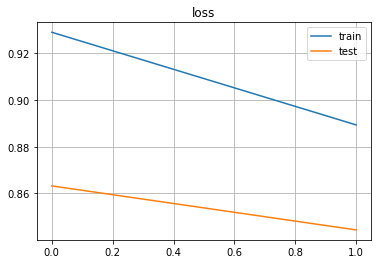

2-mins to train


INFO:tensorflow:Assets written to: C:\Users\WLX\AppData\Local\Temp\tmpl6ea0898\assets


INFO:tensorflow:Assets written to: C:\Users\WLX\AppData\Local\Temp\tmpl6ea0898\assets


INFO:tensorflow:Restoring parameters from C:\Users\WLX\AppData\Local\Temp\tmpl6ea0898\variables\variables


INFO:tensorflow:Restoring parameters from C:\Users\WLX\AppData\Local\Temp\tmpl6ea0898\variables\variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_2


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input_2


INFO:tensorflow: tensor name: serving_default_input_2:0, shape: (-1, 224, 224, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_input_2:0, shape: (-1, 224, 224, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: reshape_1


INFO:tensorflow:Tensor's key in saved_model's tensor_map: reshape_1


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 7, 7, 5, 7), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 7, 7, 5, 7), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from C:\Users\WLX\AppData\Local\Temp\tmpl6ea0898\variables\variables


INFO:tensorflow:Restoring parameters from C:\Users\WLX\AppData\Local\Temp\tmpl6ea0898\variables\variables


In [63]:
yolo = YOLO(yolo_net, yolo_loss, yolo_decoder, labels, input_size)#传入yolo_network->一个完整的yolo网络类 yolo_loss->损失函数类 yolo_decoder->yolo网络解码类 labels->标签列表 input_size->输入图片size
   # 2. Load the pretrained weights (if any) 
if alpha==1.0:
        weights='mobilenet_1_0_224_tf_no_top.h5'
elif alpha==0.75:
        weights='mobilenet_7_5_224_tf_no_top.h5'
elif alpha==0.5:
        weights='mobilenet_5_0_224_tf_no_top.h5'
elif alpha==0.25:
        weights='mobilenet_2_5_224_tf_no_top.h5'
yolo.load_weights(weights, by_name=True)#传入权重文件的路径

    #这时候yolo网络已经成功加载预权重

with warnings.catch_warnings():#忽略下面部分的waring
    warnings.simplefilter("ignore")
        # 3. actual training 
    yolo.train(config['train']['train_image_folder'],#图片对应的文件夹
                config['train']['train_annot_folder'],#xml标签对应的文件夹
                config['train']['actual_epoch'],      #训练的epoch
                weight_file,                          #保存.h5文件权重的文件夹  config['train']['saved_folder']/weights.h5
                config["train"]["batch_size"],        #每次训练喂入网络的batch
                config["train"]["jitter"],            #训练的抖动=1？
                config['train']['learning_rate'],     #学习率=0.0005
                config['train']['train_times'],       #训练次数=5？
                config['train']['valid_times'],       #有效次数=5?
                config['train']['train_image_folder'],#图片对应的文件夹
                config['train']['train_annot_folder'],#xml标签对应的文件夹
                config['train']['first_trainable_layer'],#""
                config['train']['is_only_detect'],      #为0,不只只是检测
                (len(config['model']["labels"])+5)*5, #5x(4+1+分类数),即yolo网络最后输出的大小
                config['model']['anchors'],             #锚框列表
                w_name=config['model']['architecture'], #算法名字=mobilenet
                alpha=alpha,                           #mobilenet的学习率
                lable=config['model']['labels']         #标签列表
                )
